In [1]:
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import util
from sklearn.decomposition import TruncatedSVD
from data_preprocessing import *
import word_embedding_load as wel
from classification import *
from xgboost_classifier import *
from testaccuracy import *

C:\Users\zhuya\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.
C:\Users\zhuya\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
[all_data, train_size, test_size, train_x, train_y, test_x] = util.loadData()
sentences = data_preprocess(all_data)

In [3]:
Text_INPUT_DIM=200
GENE_INPUT_DIM=25
TEXT_INPUT_DIM=200
PATH = '../model/doc2vec/'
modelName='textModel_win=2_no_outside'

In [4]:
param = util.Doc2VecParam(1, 2, 200, 1e-4, 5, 4, 30, 1)

In [5]:
svd = TruncatedSVD(n_components=GENE_INPUT_DIM, n_iter=25, random_state=12)

In [6]:
#load a pre-trained text model
text_model = wel.loadTextModel(PATH + modelName)

#To train a new text model, default without outside data:
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH)

#To train a new text model with outside data:
#sourceFile = '../data/bio_nlp_vec/PubMed-shuffle-win-30.bin'
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH, True, sourceFile)

Successfully loaded the textmodel from ../model/doc2vec/textModel_win=2_no_outside


In [7]:
truncated_one_hot_gene = wel.getGeneVec(all_data, svd)
truncated_one_hot_variation = wel.getVariationVec(all_data, svd)
text_train_arrays, text_test_arrays = wel.getTextVec(text_model, train_size, test_size, TEXT_INPUT_DIM)

In [8]:
print(text_train_arrays.shape)
print(text_test_arrays.shape)
text_train_arrays[0]

(3689, 200)
(986, 200)


array([ 1.39154303,  2.02667713, -0.2595    ,  0.40349838, -2.51128626,
       -0.57653749, -0.2880269 ,  0.79625225, -1.72736251, -0.55669445,
       -0.1103246 , -0.25622737,  0.51354522,  1.64991832,  0.15828428,
       -1.31404865, -0.38595071,  0.11359195, -1.80308282, -0.3853884 ,
        0.12366654,  0.73094928, -0.59017813, -0.57282758, -0.56738102,
       -0.58856642, -0.1689133 , -1.38690603, -1.10290945,  2.44333291,
        0.85595089, -0.83670229, -0.46628171,  0.80855757,  1.76998258,
       -1.79520845,  0.25988749, -0.36671975,  0.7018944 , -1.01795661,
        0.97518283, -0.88528377, -0.26272607, -0.72158974,  0.17883518,
       -0.84870034, -1.12246311, -1.30428255,  0.55243754, -1.49376571,
       -0.97371197, -0.530312  ,  0.11352377, -0.07217326, -1.17716205,
       -0.98013484, -0.5437516 ,  1.75924706,  1.57688129,  1.23722923,
       -0.81333536, -0.88027573,  0.03753718, -0.96783006, -2.49287248,
        0.39773917, -1.93843079,  0.16352667, -1.13692153, -1.02

In [9]:
train_set = np.hstack((truncated_one_hot_gene[:train_size], truncated_one_hot_variation[:train_size], text_train_arrays))
test_set = np.hstack((truncated_one_hot_gene[train_size:], truncated_one_hot_variation[train_size:], text_test_arrays))
encoded_y = pd.get_dummies(train_y)
encoded_y = np.array(encoded_y)
print(encoded_y.shape)

(3689, 9)


In [10]:
print(train_set.shape)
print(test_set.shape)
train_set[0, 25:50]

(3689, 250)
(986, 250)


array([  1.00000000e+00,   4.18523246e-19,   1.82140582e-19,
         5.52932734e-29,   9.01317672e-25,   1.47967745e-22,
        -8.38240178e-21,   2.00300590e-21,   9.74158370e-21,
        -9.34683441e-21,   1.91083889e-20,   6.55003880e-19,
        -1.09276438e-17,  -1.56730196e-18,  -2.12913704e-18,
        -4.51096312e-18,  -3.82900024e-19,   1.15894157e-17,
         1.59938703e-17,   3.58735292e-17,  -3.35304994e-18,
         1.68462844e-17,   6.76851697e-18,   5.86047343e-17,
         7.80129580e-21])

In [13]:
# this is the 4 layer full-connected nerual network model
model = nn_baseline_model(TEXT_INPUT_DIM, GENE_INPUT_DIM, GENE_INPUT_DIM)
model.summary()

C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="normal", activation="relu", input_dim=250)`
  model.add(Dense(256, input_dim=Text_INPUT_DIM+ Gene_INPUT_DIM + Variation_INPUT_DIM, init='normal', activation='relu'))
C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal")`
  model.add(Dense(256, init='normal', activation='relu'))
C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_initializer="normal")`
  model.add(Dense(80, init='normal', activation='relu'))
C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:33: UserWarning: Update your `De

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               64256     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 729       
Total params: 151,337
Trainable params: 151,337
Non-trainable params: 0
_________________________________________________________________


begin training

Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 13s - loss: 2.1812 - acc: 0.12 - ETA: 1s - loss: 2.1581 - acc: 0.1777 - ETA: 0s - loss: 2.1186 - acc: 0.220 - ETA: 0s - loss: 2.0727 - acc: 0.245 - ETA: 0s - loss: 2.0127 - acc: 0.261 - ETA: 0s - loss: 1.9784 - acc: 0.268 - 0s - loss: 1.9651 - acc: 0.2769 - val_loss: 1.7104 - val_acc: 0.4377
Epoch 2/2
2951/2951 [==============================] - ETA: 0s - loss: 1.8472 - acc: 0.234 - ETA: 0s - loss: 1.8114 - acc: 0.368 - ETA: 0s - loss: 1.7475 - acc: 0.394 - ETA: 0s - loss: 1.7202 - acc: 0.401 - ETA: 0s - loss: 1.7133 - acc: 0.397 - 0s - loss: 1.6917 - acc: 0.4036 - val_loss: 1.4350 - val_acc: 0.4702
Training accuracy: 40.36% / Best validation accuracy: 47.02%
Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 0s - loss: 1.5541 - acc: 0.421 - ETA: 0s - loss: 1.5455 - acc: 0.409 - ETA: 0s - loss: 1.5431 - acc: 0

2951/2951 [==============================] - ETA: 0s - loss: 0.9617 - acc: 0.656 - ETA: 0s - loss: 1.0104 - acc: 0.618 - ETA: 0s - loss: 0.9209 - acc: 0.638 - ETA: 0s - loss: 0.9158 - acc: 0.650 - ETA: 0s - loss: 0.9115 - acc: 0.653 - ETA: 0s - loss: 0.9010 - acc: 0.661 - 0s - loss: 0.8991 - acc: 0.6635 - val_loss: 1.2034 - val_acc: 0.5352
Training accuracy: 66.35% / Best validation accuracy: 54.07%
Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 0s - loss: 0.7272 - acc: 0.687 - ETA: 0s - loss: 0.9255 - acc: 0.673 - ETA: 0s - loss: 0.9199 - acc: 0.662 - ETA: 0s - loss: 0.8985 - acc: 0.672 - ETA: 0s - loss: 0.8999 - acc: 0.671 - ETA: 0s - loss: 0.8997 - acc: 0.673 - 0s - loss: 0.8892 - acc: 0.6754 - val_loss: 1.2087 - val_acc: 0.5244
Epoch 2/2
2951/2951 [==============================] - ETA: 0s - loss: 0.7007 - acc: 0.750 - ETA: 0s - loss: 0.8495 - acc: 0.691 - ETA: 0s - loss: 0.8456 - acc: 0.694 - ETA: 0s - loss: 0.8587 - acc:

2951/2951 [==============================] - ETA: 0s - loss: 0.6380 - acc: 0.781 - ETA: 0s - loss: 0.7566 - acc: 0.738 - ETA: 0s - loss: 0.7261 - acc: 0.729 - ETA: 0s - loss: 0.7284 - acc: 0.724 - ETA: 0s - loss: 0.7172 - acc: 0.729 - ETA: 0s - loss: 0.7092 - acc: 0.732 - 0s - loss: 0.7015 - acc: 0.7384 - val_loss: 1.2439 - val_acc: 0.5366
Training accuracy: 73.84% / Best validation accuracy: 54.34%
Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 0s - loss: 0.7204 - acc: 0.750 - ETA: 0s - loss: 0.7140 - acc: 0.762 - ETA: 0s - loss: 0.7009 - acc: 0.745 - ETA: 0s - loss: 0.7033 - acc: 0.744 - ETA: 0s - loss: 0.7013 - acc: 0.738 - 0s - loss: 0.7121 - acc: 0.7350 - val_loss: 1.2402 - val_acc: 0.5488
Epoch 2/2
2951/2951 [==============================] - ETA: 0s - loss: 0.6080 - acc: 0.765 - ETA: 0s - loss: 0.7346 - acc: 0.729 - ETA: 0s - loss: 0.7420 - acc: 0.724 - ETA: 0s - loss: 0.7381 - acc: 0.723 - ETA: 0s - loss: 0.7290 - acc:

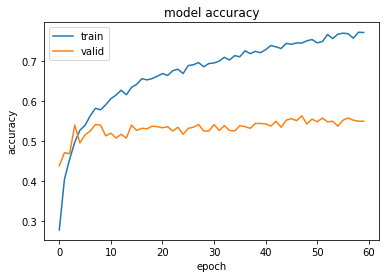

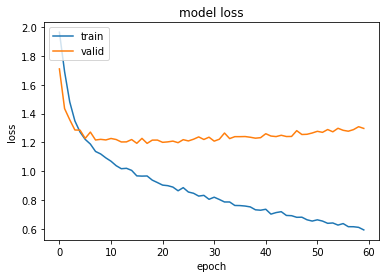

832/986 [========================>.....] - ETA:  - ETA: 0s

In [14]:
model = train_nn_model(model, train_set, encoded_y, filename = 'try(win2).h5')
y_predict = model.predict_proba(test_set)

In [15]:
#the xgboost classfication model
#first deal with the input label, transfrom it from 1-9 to 0-8(required by the xgboost)
for i in range(len(train_y)):
    train_y[i] -=1  

In [16]:
y_predict = xgbclassifier(train_set, train_y, test_set, 1, 8, 1000)

[0]	train-mlogloss:2.11745	valid-mlogloss:2.1404
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.05798	valid-mlogloss:1.44264
[50]	train-mlogloss:0.610543	valid-mlogloss:1.18428
[75]	train-mlogloss:0.381413	valid-mlogloss:1.05781
[100]	train-mlogloss:0.258938	valid-mlogloss:0.994616
[125]	train-mlogloss:0.177905	valid-mlogloss:0.964828
[150]	train-mlogloss:0.126354	valid-mlogloss:0.95418
[175]	train-mlogloss:0.091554	valid-mlogloss:0.95067
[200]	train-mlogloss:0.068454	valid-mlogloss:0.951511
[225]	train-mlogloss:0.05209	valid-mlogloss:0.957504
[250]	train-mlogloss:0.041341	valid-mlogloss:0.965543
Stopping. Best iteration:
[172]	train-mlogloss:0.095087	valid-mlogloss:0.949843

0.949843439014
1


In [18]:
savesubmisstion(y_predict, test_x, filename = "submission_allwin2noload.csv")